# 🛒 Hệ thống Đề xuất cho Bán lẻ/Thương mại điện tử (Phiên bản đầy đủ với Trực quan hóa)

- **Tích hợp Toàn bộ Dữ liệu**: Sử dụng `events`, `item_properties`, và `category_tree`.
- **Trực quan hóa**: Bao gồm các so sánh trước/sau khi xử lý dữ liệu và ảnh hưởng của tinh chỉnh siêu tham số.
- **Mô hình Hybrid GRU4Rec**: Nâng cấp GRU4Rec để học từ cả ID sản phẩm và ID danh mục.
- **So sánh Toàn diện**: Đánh giá hiệu suất của Hybrid GRU4Rec so với SVD và Most Popular.
- **Demo & Giải thích**: Cung cấp demo và các bình luận chi tiết bằng tiếng Việt cho người mới học.

In [1]:
# --- CÀI ĐẶT CÁC THƯ VIỆN CẦN THIẾT ---
# Chạy cell này để cài đặt các thư viện cần thiết nếu môi trường của bạn chưa có.
# !pip install pandas numpy scikit-learn torch matplotlib scikit-surprise

## 1. Tải Toàn bộ Dữ liệu

--- Đang tải tất cả các nguồn dữ liệu ---
--- Thống kê dữ liệu thô ban đầu ---


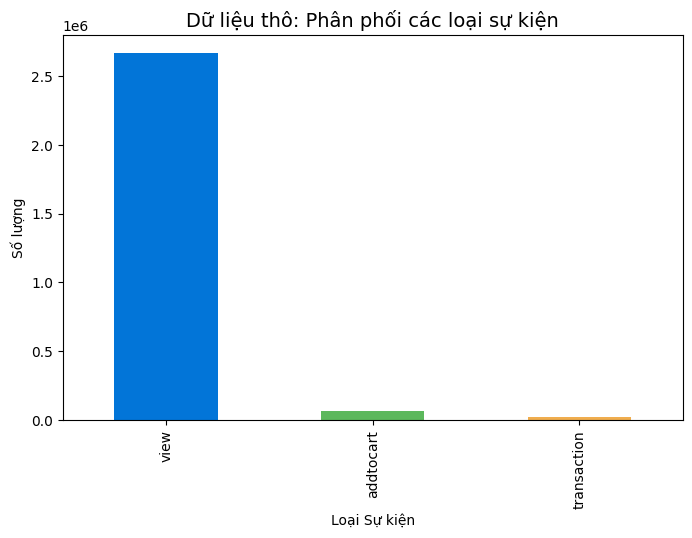

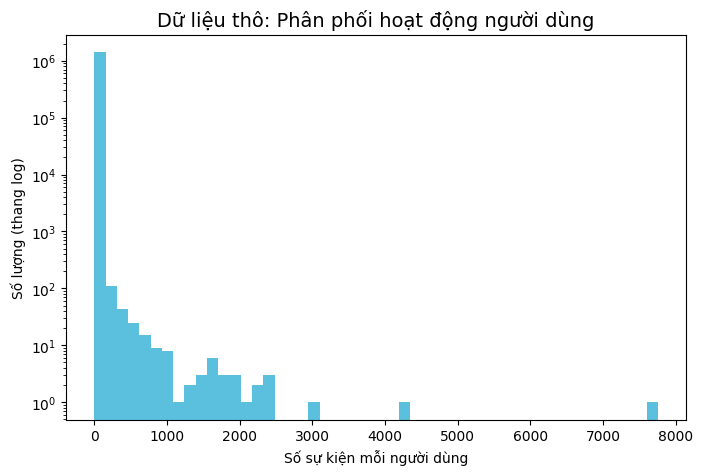

In [2]:
import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from collections import defaultdict

print("--- Đang tải tất cả các nguồn dữ liệu ---")
events = pd.read_csv('events.csv')
category_tree = pd.read_csv('category_tree.csv') 
item_properties_1 = pd.read_csv('item_properties_part1.csv')
item_properties_2 = pd.read_csv('item_properties_part2.csv')
item_properties = pd.concat([item_properties_1, item_properties_2], ignore_index=True)

# Lưu lại các thông số của dữ liệu thô để so sánh sau này
raw_events_stats = {
    'total_events': events.shape[0],
    'unique_users': events['visitorid'].nunique(),
    'unique_items': events['itemid'].nunique()
}

# Hàm vẽ biểu đồ để trực quan hóa
def plot_event_type_bar(df, title):
    plt.figure(figsize=(8,5))
    df['event'].value_counts().plot(kind='bar', color=['#0275d8','#5cb85c','#f0ad4e'])
    plt.title(title, fontsize=14)
    plt.xlabel("Loại Sự kiện")
    plt.ylabel("Số lượng")
    plt.show()

def plot_hist_by_group(df, group_col, title, xlabel, color):
    plt.figure(figsize=(8,5))
    df.groupby(group_col).size().plot(kind='hist', bins=50, log=True, color=color)
    plt.title(title, fontsize=14)
    plt.xlabel(xlabel)
    plt.ylabel("Số lượng (thang log)")
    plt.show()

print("--- Thống kê dữ liệu thô ban đầu ---")
plot_event_type_bar(events, "Dữ liệu thô: Phân phối các loại sự kiện")
plot_hist_by_group(events, 'visitorid', "Dữ liệu thô: Phân phối hoạt động người dùng", "Số sự kiện mỗi người dùng", '#5bc0de')

## 2. Tiền xử lý & Hợp nhất Dữ liệu

In [ ]:
# --- BƯỚC 2: TIỀN XỬ LÝ VÀ HỢP NHẤT DỮ LIỆU ---
# Đây là giai đoạn quan trọng nhất, nơi chúng ta "làm sạch" và kết hợp các nguồn dữ liệu thô
# để tạo ra một bộ dữ liệu chất lượng cao, sẵn sàng cho việc xây dựng đặc trưng và huấn luyện mô hình.

# --- 2.1: Tiền xử lý Dữ liệu Thuộc tính Sản phẩm (Item Properties) ---
print("--- Đang xử lý thuộc tính sản phẩm để trích xuất danh mục ---")

# Chuyển đổi cột timestamp (dạng số) sang định dạng datetime để có thể xử lý theo thời gian.
item_properties['datetime'] = pd.to_datetime(item_properties['timestamp'], unit='ms')

# File item_properties chứa nhiều loại thuộc tính khác nhau. Theo phân tích trong báo cáo,
# 'categoryid' là thuộc tính hữu ích nhất cho mô hình đề xuất của chúng ta.
# Do đó, chúng ta chỉ lọc ra những dòng có thuộc tính là 'categoryid'.
item_categories = item_properties[item_properties['property'] == 'categoryid'].copy()

# File này là một log ghi lại các thay đổi thuộc tính theo thời gian. Một sản phẩm có thể
# có nhiều 'categoryid' khác nhau tại các thời điểm khác nhau.
# Chúng ta sắp xếp dữ liệu theo thời gian giảm dần (từ mới nhất đến cũ nhất).
item_categories = item_categories.sort_values('datetime', ascending=False)

# Sau khi sắp xếp, dòng đầu tiên cho mỗi 'itemid' sẽ là thông tin danh mục gần đây nhất.
# Chúng ta dùng .drop_duplicates() để xóa các dòng trùng lặp, chỉ giữ lại dòng đầu tiên (keep='first').
item_categories = item_categories.drop_duplicates(subset='itemid', keep='first')

# Chọn ra các cột cần thiết ('itemid', 'value') và đổi tên cột 'value' thành 'categoryid' cho dễ hiểu.
item_categories = item_categories[['itemid', 'value']].rename(columns={'value': 'categoryid'})

# Chuyển đổi kiểu dữ liệu của cột 'categoryid' sang số nguyên.
item_categories['categoryid'] = item_categories['categoryid'].astype(int)
print("Xử lý danh mục sản phẩm hoàn tất.")


# --- 2.2: Làm sạch Dữ liệu Sự kiện (Events) ---
print("--- Đang làm sạch dữ liệu sự kiện ---")

# Xóa các dòng bị trùng lặp hoàn toàn. Thêm .copy() để tránh cảnh báo SettingWithCopyWarning.
events = events.drop_duplicates().copy()

# Chuyển đổi timestamp sang datetime.
events['datetime'] = pd.to_datetime(events['timestamp'], unit='ms')

# Lọc bỏ bot (các chương trình tự động):
# 1. Gom nhóm các sự kiện theo từng người dùng ('visitorid') trong từng giờ ('freq='h'').
# 2. Đếm số lượng sự kiện trong mỗi nhóm.
user_hour = events.groupby(['visitorid', pd.Grouper(key='datetime', freq='h')]).size().reset_index(name='event_count')
# 3. Nếu một người dùng có hơn 200 sự kiện trong 1 giờ, ta coi đó là bot và lấy ID của họ.
bots = user_hour[user_hour['event_count'] > 200]['visitorid'].unique()
# 4. Loại bỏ tất cả các sự kiện từ những ID được xác định là bot.
events = events[~events['visitorid'].isin(bots)]

# Giảm độ thưa của dữ liệu (Sparsity Reduction):
# Để mô hình học tốt hơn, chúng ta chỉ giữ lại những người dùng và sản phẩm có đủ lượng tương tác.
# 1. Đếm số lần tương tác của mỗi người dùng và chỉ giữ lại những người có từ 5 tương tác trở lên.
active_users = events['visitorid'].value_counts()[lambda x: x >= 5].index
# 2. Tương tự, chỉ giữ lại những sản phẩm có từ 5 tương tác trở lên.
active_items = events['itemid'].value_counts()[lambda x: x >= 5].index
# 3. Lọc DataFrame `events` để chỉ chứa dữ liệu từ những người dùng và sản phẩm tích cực này.
#    Thêm .copy() để tạo một DataFrame mới, độc lập.
events = events[events['visitorid'].isin(active_users) & events['itemid'].isin(active_items)].copy()
print("Làm sạch dữ liệu sự kiện hoàn tất.")


# --- 2.3: Hợp nhất các nguồn dữ liệu ---
print("--- Đang hợp nhất tất cả các nguồn dữ liệu ---")

# Sử dụng hàm .merge() để ghép bảng events (đã làm sạch) với bảng item_categories đã xử lý.
# 'on='itemid'': Ghép dựa trên cột chung là 'itemid'.
# 'how='left'': Giữ lại tất cả các dòng từ bảng events, kể cả khi không tìm thấy thông tin category tương ứng.
events_merged = events.merge(item_categories, on='itemid', how='left')

# Với những sản phẩm không có thông tin category (giá trị bị thiếu - NaN),
# chúng ta sẽ điền giá trị -1 làm giá trị thay thế (placeholder).
# Sử dụng .loc[:, 'column'] để đảm bảo thao tác được thực hiện trên DataFrame gốc, tránh cảnh báo.
events_merged.loc[:, 'categoryid'] = events_merged['categoryid'].fillna(-1)

# Chuyển đổi kiểu dữ liệu của cột categoryid sang số nguyên.
events_merged['categoryid'] = events_merged['categoryid'].astype(int)
print("Hợp nhất hoàn tất.")

--- Đang xử lý thuộc tính sản phẩm để trích xuất danh mục ---
Xử lý danh mục sản phẩm hoàn tất.
--- Đang làm sạch dữ liệu sự kiện ---
Làm sạch dữ liệu sự kiện hoàn tất.
--- Đang hợp nhất tất cả các nguồn dữ liệu ---
Hợp nhất hoàn tất.


### 2a. Trực quan hóa Ảnh hưởng của Tiền xử lý

--- Bảng so sánh dữ liệu ---


,total_events,unique_users,unique_items
Trước Khi Xử Lý,2756101,1407580,235061
Sau Khi Xử Lý,895965,81287,67541



--- Biểu đồ so sánh phân phối hoạt động người dùng ---


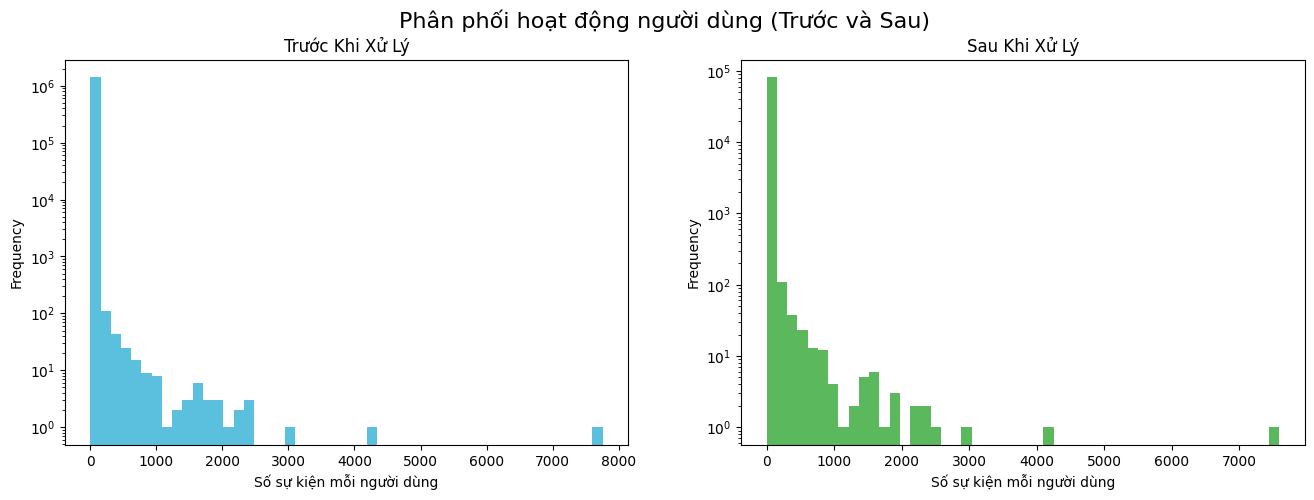

In [4]:
# --- So sánh các chỉ số chính trước và sau khi làm sạch ---
cleaned_events_stats = {
    'total_events': events_merged.shape[0],
    'unique_users': events_merged['visitorid'].nunique(),
    'unique_items': events_merged['itemid'].nunique()
}

comparison_df = pd.DataFrame([raw_events_stats, cleaned_events_stats], index=['Trước Khi Xử Lý', 'Sau Khi Xử Lý'])
print("--- Bảng so sánh dữ liệu ---")
display(comparison_df)

# --- Biểu đồ so sánh phân phối ---
# Tải lại dữ liệu thô gốc để đảm bảo biểu đồ 'Trước' là chính xác
raw_events_df = pd.read_csv('events.csv')

print("\n--- Biểu đồ so sánh phân phối hoạt động người dùng ---")
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
raw_events_df.groupby('visitorid').size().plot(kind='hist', bins=50, log=True, ax=axes[0], color='#5bc0de', title='Trước Khi Xử Lý')
events_merged.groupby('visitorid').size().plot(kind='hist', bins=50, log=True, ax=axes[1], color='#5cb85c', title='Sau Khi Xử Lý')
axes[0].set_xlabel('Số sự kiện mỗi người dùng')
axes[1].set_xlabel('Số sự kiện mỗi người dùng')
plt.suptitle('Phân phối hoạt động người dùng (Trước và Sau)', fontsize=16)
plt.show()

## 3. Xây dựng Đặc trưng (Feature Engineering)

In [5]:
# --- BƯỚC 3: XÂY DỰNG ĐẶC TRƯNG (FEATURE ENGINEERING) ---
# Ở bước này, chúng ta sẽ tạo ra các cột dữ liệu mới (gọi là "đặc trưng" hay "feature")
# từ dữ liệu gốc để giúp mô hình AI "hiểu" rõ hơn về hành vi người dùng.

print("--- Bắt đầu xây dựng đặc trưng ---")
# Tạo một bản sao của DataFrame đã hợp nhất để tránh làm thay đổi dữ liệu gốc.
df = events_merged.copy()

# --- 3.1: Phân chia Session (Sessionization) ---
# Một "session" (phiên) là một chuỗi các hành động của người dùng trong một lần truy cập.
# Việc xác định các session là cực kỳ quan trọng để hiểu được hành vi theo ngữ cảnh.

# Sắp xếp dữ liệu theo người dùng và thời gian để đảm bảo các sự kiện được xử lý đúng thứ tự.
df = df.sort_values(['visitorid', 'datetime'])

# Tạo một cột số thứ tự cho mỗi session của từng người dùng.
# Logic hoạt động như sau:
# 1. groupby('visitorid')['datetime']: Nhóm các sự kiện theo từng người dùng.
# 2. .diff(): Tính toán khoảng thời gian giữa sự kiện hiện tại và sự kiện ngay trước đó.
# 3. .gt(timedelta(minutes=30)): Kiểm tra xem khoảng thời gian đó có lớn hơn 30 phút không. Kết quả là True/False.
# 4. .cumsum(): Tạo một tổng tích lũy. Mỗi khi gặp giá trị True (nghỉ quá 30 phút), tổng sẽ tăng lên 1,
#    đánh dấu một session mới đã bắt đầu.
df['session_id_num'] = (df.groupby('visitorid')['datetime'].diff().gt(timedelta(minutes=30))).cumsum().astype(int)

# Tạo ra một cột 'session_id' duy nhất bằng cách kết hợp ID người dùng và số thứ tự session.
# Ví dụ: visitorid '123' và session_id_num '0' -> session_id '123_0'
df['session_id'] = df['visitorid'].astype(str) + '_' + df['session_id_num'].astype(str)


# --- 3.2: Gán trọng số cho sự kiện (Event Weighting) ---
# Các hành động khác nhau của người dùng thể hiện mức độ quan tâm khác nhau.
# Ví dụ, "thêm vào giỏ" (addtocart) thể hiện ý định mua hàng mạnh hơn là chỉ "xem" (view).
# Chúng ta sẽ gán một con số (trọng số) để thể hiện mức độ quan trọng này.
event_map = {'view': 1, 'addtocart': 3, 'transaction': 5}
df['event_weight'] = df['event'].map(event_map)


# --- 3.3: Mã hóa ID (ID Encoding) ---
# Các mô hình AI, đặc biệt là các mạng nơ-ron, làm việc hiệu quả hơn với các con số nguyên liên tục
# (ví dụ: 0, 1, 2,...) thay vì các ID dạng chuỗi ký tự dài và không có thứ tự.
# Chúng ta sẽ dùng LabelEncoder để "ánh xạ" mỗi ID duy nhất (user, item, category) thành một số nguyên.
# Việc này giống như cấp cho mỗi người một số báo danh.

# Khởi tạo các bộ mã hóa
user_enc = LabelEncoder()
item_enc = LabelEncoder()
cat_enc = LabelEncoder()

# Áp dụng mã hóa cho từng cột ID để tạo ra các cột chỉ số (index) mới.
# .fit_transform() sẽ học và chuyển đổi các ID trong một lần.
df['user_idx'] = user_enc.fit_transform(df['visitorid'])
df['item_idx'] = item_enc.fit_transform(df['itemid'])
df['category_idx'] = cat_enc.fit_transform(df['categoryid'])

print("Xây dựng đặc trưng hoàn tất.")

--- Bắt đầu xây dựng đặc trưng ---
Xây dựng đặc trưng hoàn tất.


## 4. Phân chia Dữ liệu (Theo Thời gian)

In [6]:
# --- BƯỚC 4: PHÂN CHIA DỮ LIỆU (THEO THỜI GIAN) ---
# Đây là một bước cực kỳ quan trọng trong các bài toán có yếu tố thời gian, như hệ thống đề xuất.
# Chúng ta sẽ chia dữ liệu thành 3 phần:
# 1. Tập Huấn luyện (train): Dùng để "dạy" cho mô hình học các mẫu hành vi.
# 2. Tập Kiểm định (validation): Dùng để tinh chỉnh các siêu tham số của mô hình (ví dụ: tốc độ học, độ phức tạp).
# 3. Tập Kiểm tra (test): Dùng để đánh giá hiệu suất cuối cùng của mô hình trên dữ liệu mà nó chưa từng thấy.

# Cách chia theo thời gian (Temporal Split) là rất cần thiết để mô phỏng đúng thực tế:
# chúng ta dùng dữ liệu quá khứ để dự đoán hành vi trong tương lai.
# Điều này giúp tránh "rò rỉ dữ liệu" (data leakage), tức là mô hình biết trước thông tin mà lẽ ra nó không được biết.

# Lấy ra ngày tháng mới nhất trong toàn bộ dữ liệu.
max_date = df['datetime'].max()

# Đặt mốc thời gian để cắt dữ liệu.
# - Dữ liệu huấn luyện (train) sẽ là tất cả dữ liệu TRƯỚC 2 tuần cuối cùng.
# - Dữ liệu kiểm định (validation) sẽ là dữ liệu trong tuần áp chót.
# - Dữ liệu kiểm tra (test) sẽ là dữ liệu trong tuần cuối cùng.
train_cutoff = max_date - timedelta(weeks=2)
val_cutoff = max_date - timedelta(weeks=1)

# Thực hiện việc cắt dữ liệu dựa trên các mốc thời gian đã định.
# train: chứa các sự kiện xảy ra trước mốc train_cutoff.
train = df[df['datetime'] < train_cutoff]
# valid: chứa các sự kiện xảy ra từ mốc train_cutoff đến trước mốc val_cutoff.
valid = df[(df['datetime'] >= train_cutoff) & (df['datetime'] < val_cutoff)]
# test: chứa các sự kiện xảy ra từ mốc val_cutoff trở về sau.
test = df[df['datetime'] >= val_cutoff]

## 5. Huấn luyện các Mô hình

### Model 1: Most Popular (Mô hình cơ sở)

In [7]:
# Đây là mô hình đơn giản nhất, không mang tính cá nhân hóa.
# Mục đích của nó là tạo ra một "mức hiệu suất tối thiểu" (baseline) để chúng ta có thể
# so sánh và đánh giá hiệu quả của các mô hình phức tạp hơn sau này.
# Logic của mô hình này rất đơn giản: "Đề xuất những sản phẩm được nhiều người tương tác nhất."

# Dòng code này thực hiện các bước sau:
# 1. train['item_idx']: Chọn cột chứa ID của các sản phẩm (đã được mã hóa thành số nguyên) từ tập dữ liệu huấn luyện.
# 2. .value_counts(): Đếm số lần xuất hiện của mỗi ID sản phẩm. Kết quả là một danh sách các sản phẩm được sắp xếp theo mức độ phổ biến giảm dần.
# 3. .index: Lấy ra chỉ các ID sản phẩm từ kết quả trên (bỏ đi số lần đếm).
# 4. [:20]: Chọn ra 20 sản phẩm đầu tiên trong danh sách, tức là 20 sản phẩm phổ biến nhất.
# 5. .tolist(): Chuyển danh sách 20 ID sản phẩm này thành một list trong Python.
most_popular = train['item_idx'].value_counts().index[:20].tolist()

### Model 2: SVD Collaborative Filtering (Mô hình cơ sở)

In [8]:
# --- BƯỚC 5.2: XÂY DỰNG MÔ HÌNH CƠ SỞ "LỌC CỘNG TÁC SVD" ---
# Đây là một mô hình cá nhân hóa cơ sở, mạnh hơn "Most Popular".
# Ý tưởng chính của Lọc cộng tác (Collaborative Filtering) là: "Nếu bạn và một người khác
# cùng thích những sản phẩm giống nhau, thì có khả năng bạn cũng sẽ thích những sản phẩm
# mà người đó đã thích nhưng bạn chưa xem."

# Chúng ta sẽ sử dụng thư viện `surprise`, một thư viện rất phổ biến và hiệu quả cho các bài toán đề xuất.
from surprise import Dataset, Reader, SVD

# Khởi tạo biến svd_model là None. Biến này sẽ chứa mô hình đã được huấn luyện của chúng ta.
svd_model = None

# Sử dụng khối lệnh try...except để xử lý lỗi một cách an toàn.
# Nếu có bất kỳ lỗi nào xảy ra trong quá trình huấn luyện (ví dụ: thiếu thư viện, lỗi dữ liệu),
# chương trình sẽ không bị dừng lại mà sẽ in ra thông báo lỗi.
try:
    # 1. Chuẩn bị dữ liệu cho thư viện Surprise
    # Thư viện này yêu cầu dữ liệu phải có định dạng cụ thể (user, item, rating).
    # Chúng ta cần định nghĩa một 'Reader' để chỉ định thang điểm cho các "đánh giá".
    # Trong trường hợp này, thang điểm của chúng ta là trọng số sự kiện (event_weight), từ 1 đến 5.
    reader = Reader(rating_scale=(1, 5))
    
    # Tải dữ liệu từ DataFrame của pandas vào định dạng của Surprise.
    # Chúng ta chỉ lấy 3 cột cần thiết: 'user_idx', 'item_idx', và 'event_weight'.
    data = Dataset.load_from_df(train[['user_idx', 'item_idx', 'event_weight']], reader)
    
    # Xây dựng tập huấn luyện (trainset) từ toàn bộ dữ liệu đã được tải.
    # Đây là cấu trúc dữ liệu nội bộ mà Surprise sử dụng để huấn luyện mô hình.
    trainset = data.build_full_trainset()
    
    # 2. Khởi tạo và huấn luyện mô hình SVD (Singular Value Decomposition)
    # SVD là một thuật toán phân rã ma trận mạnh mẽ, giúp tìm ra các "đặc trưng ẩn" (latent factors)
    # của người dùng và sản phẩm để đưa ra dự đoán.
    # - n_factors: Số lượng đặc trưng ẩn mà mô hình sẽ học (ví dụ: 50).
    # - n_epochs: Số lần mô hình sẽ lặp qua toàn bộ dữ liệu để học (ví dụ: 20).
    # - random_state: Giúp kết quả có thể được tái tạo lại.
    # - verbose=True: In ra tiến trình huấn luyện.
    svd_model = SVD(n_factors=50, n_epochs=20, random_state=42, verbose=True)
    
    # Bắt đầu quá trình huấn luyện mô hình với tập trainset.
    svd_model.fit(trainset)
    
    print("--- Huấn luyện mô hình SVD hoàn tất. ---")

except Exception as e:
    # Nếu có lỗi, in ra thông báo.
    print(f"--- Không thể huấn luyện mô hình SVD: {e} ---")
    svd_model = None

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
--- Huấn luyện mô hình SVD hoàn tất. ---


### Model 3: Hybrid GRU4Rec (Mô hình chính)

In [9]:
# --- BƯỚC 5.3: XÂY DỰNG VÀ HUẤN LUYỆN MÔ HÌNH HYBRID GRU4REC ---
# Nhập các thư viện cần thiết từ PyTorch để xây dựng mô hình mạng nơ-ron.
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# --- 5.3.1: Định nghĩa Lớp Dataset ---
# Lớp HybridSessionDataset dùng để chuẩn bị và cung cấp dữ liệu theo từng phiên (session) cho mô hình.
# Nó biến đổi DataFrame của chúng ta thành định dạng mà PyTorch có thể đọc và xử lý được.
class HybridSessionDataset(Dataset):
    # Hàm khởi tạo, được gọi khi một đối tượng của lớp được tạo ra.
    def __init__(self, df, maxlen=10):
        self.df = df
        # Gom nhóm các sự kiện theo 'session_id'. Với mỗi session,
        # ta tạo ra một cặp tuple chứa danh sách các item_idx và category_idx tương ứng.
        session_groups = df.groupby('session_id')
        self.sessions = [
            (group['item_idx'].tolist(), group['category_idx'].tolist())
            for name, group in session_groups
        ]
        
        # Tạo ra các mẫu (samples) huấn luyện từ các session.
        # Mỗi mẫu là một cặp (đầu vào, đầu ra).
        # Ví dụ: session [A, B, C] -> tạo ra ( [A], B ) và ( [A, B], C )
        self.samples = []
        for item_seq, cat_seq in self.sessions:
            for i in range(1, len(item_seq)):
                start = max(0, i - maxlen)
                # 'samples' chứa một cặp tuple: ((chuỗi item đầu vào, chuỗi category đầu vào), item mục tiêu)
                self.samples.append(((item_seq[start:i], cat_seq[start:i]), item_seq[i]))

    # Hàm trả về tổng số mẫu huấn luyện.
    def __len__(self):
        return len(self.samples)

    # Hàm lấy một mẫu dữ liệu tại một chỉ số (idx) cụ thể.
    # Đây là nơi dữ liệu được định dạng lại thành Tensor để đưa vào mô hình.
    def __getitem__(self, idx):
        (item_seq, cat_seq), label = self.samples[idx]
        # Tạo ra các mảng numpy có độ dài cố định (maxlen=10) và điền các chuỗi đầu vào.
        # Việc này đảm bảo tất cả đầu vào cho mô hình có cùng kích thước.
        item_x = np.zeros(10, dtype=int)
        cat_x = np.zeros(10, dtype=int)
        item_x[-len(item_seq):] = item_seq[-10:]
        cat_x[-len(cat_seq):] = cat_seq[-10:]
        # Trả về dữ liệu dưới dạng Tensor, là định dạng PyTorch sử dụng.
        return torch.LongTensor(item_x), torch.LongTensor(cat_x), torch.LongTensor([label])

# --- 5.3.2: Định nghĩa Kiến trúc Mô hình ---
# Lớp HybridGRU4Rec định nghĩa kiến trúc của mạng nơ-ron.
# Kế thừa từ nn.Module, lớp cơ sở cho mọi mô hình trong PyTorch.
class HybridGRU4Rec(nn.Module):
    # Hàm khởi tạo kiến trúc của mô hình.
    def __init__(self, n_items, n_cats, item_emb_dim=50, cat_emb_dim=10, hid_dim=100):
        super().__init__()
        # Lớp Embedding cho sản phẩm: Biến mỗi ID sản phẩm (một số nguyên) thành một véc-tơ dày đặc
        # có 'item_emb_dim' chiều. Véc-tơ này sẽ học cách biểu diễn "tính cách" của sản phẩm.
        self.item_embedding = nn.Embedding(n_items, item_emb_dim)
        
        # Lớp Embedding cho danh mục: Tương tự, biến mỗi ID danh mục thành một véc-tơ.
        self.cat_embedding = nn.Embedding(n_cats, cat_emb_dim)
        
        # Lớp GRU (Gated Recurrent Unit): Một loại mạng nơ-ron có khả năng ghi nhớ thông tin từ một chuỗi.
        # Kích thước đầu vào của nó là tổng kích thước của embedding sản phẩm và embedding danh mục.
        self.gru = nn.GRU(item_emb_dim + cat_emb_dim, hid_dim, batch_first=True)
        
        # Lớp Linear (Fully Connected): Lớp đầu ra, biến đổi trạng thái ẩn của GRU thành điểm số cho tất cả các sản phẩm.
        self.fc = nn.Linear(hid_dim, n_items)

    # Hàm forward: Định nghĩa cách dữ liệu chảy qua các lớp của mô hình.
    def forward(self, item_x, cat_x):
        # Lấy véc-tơ embedding cho chuỗi sản phẩm và danh mục.
        item_emb = self.item_embedding(item_x)
        cat_emb = self.cat_embedding(cat_x)
        
        # Nối (concatenate) hai véc-tơ embedding lại với nhau để tạo thành một đầu vào "hybrid".
        # Đây là bước cốt lõi của mô hình lai này.
        combined_emb = torch.cat([item_emb, cat_emb], dim=2)
        
        # Đưa embedding kết hợp qua lớp GRU để nắm bắt thông tin tuần tự.
        # GRU trả về output và trạng thái ẩn cuối cùng (h).
        _, h = self.gru(combined_emb)
        
        # Đưa trạng thái ẩn cuối cùng của GRU qua lớp Linear để có được điểm số dự đoán cho mỗi sản phẩm.
        out = self.fc(h.squeeze(0))
        return out

# --- 5.3.3: Chuẩn bị các tham số và DataLoader ---
# Lấy tổng số sản phẩm và danh mục duy nhất để định nghĩa kích thước cho các lớp Embedding.
n_items = df['item_idx'].nunique()
n_cats = df['category_idx'].nunique()

# Chọn thiết bị để huấn luyện mô hình: ưu tiên GPU ('cuda') nếu có, nếu không thì dùng CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### 5a. Tinh chỉnh Siêu tham số cho Hybrid GRU4Rec

--- Bắt đầu Tinh chỉnh Siêu tham số cho Hybrid GRU4Rec ---
Tinh chỉnh với: lr=0.001, hid_dim=100
Validation Recall@20: 0.3552
Tinh chỉnh với: lr=0.001, hid_dim=150
Validation Recall@20: 0.3847
Tinh chỉnh với: lr=0.005, hid_dim=100
Validation Recall@20: 0.3843
Tinh chỉnh với: lr=0.005, hid_dim=150
Validation Recall@20: 0.3913
--- Hoàn tất Tinh chỉnh ---
Các tham số tốt nhất được tìm thấy: {'lr': 0.005, 'hid_dim': 150, 'recall': 0.39134068873286526}


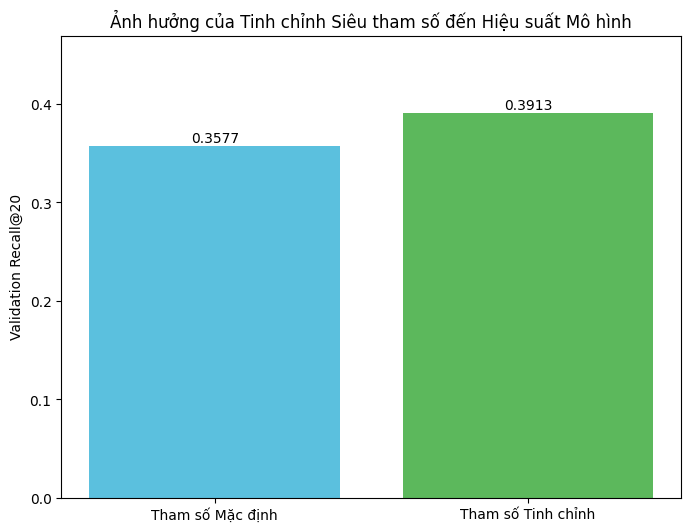

In [10]:
# --- BƯỚC 5a: TINH CHỈNH SIÊU THAM SỐ CHO HYBRID GRU4REC ---
# "Siêu tham số" (Hyperparameter) là các cài đặt của mô hình mà chúng ta phải chọn trước khi huấn luyện
# (ví dụ: tốc độ học, độ phức tạp của mô hình).
# "Tinh chỉnh" (Tuning) là quá trình thử nghiệm các cài đặt khác nhau để tìm ra bộ cài đặt tốt nhất.

def evaluate_hybrid_model(model, val_df, k=20):
    """
    Hàm này dùng để đánh giá hiệu suất của một mô hình GRU4Rec trên tập dữ liệu kiểm định (validation).
    Nó sẽ tính toán chỉ số Recall@20: tỷ lệ các sản phẩm đúng được mô hình đoán trúng trong top 20 đề xuất.
    """
    model.eval() # Chuyển mô hình sang chế độ đánh giá (không học nữa).
    recalls = []
    # Chuẩn bị dữ liệu từ tập validation theo từng session.
    session_groups = val_df.groupby('session_id')
    val_sessions = [(group['item_idx'].tolist(), group['category_idx'].tolist()) for name, group in session_groups]
    
    with torch.no_grad(): # Tắt việc tính toán gradient để tăng tốc độ.
        for item_seq, cat_seq in val_sessions:
            if len(item_seq) < 2: continue
            # Chuẩn bị đầu vào (sản phẩm đã xem) và đầu ra (sản phẩm đúng tiếp theo).
            item_input = torch.LongTensor([item_seq[:-1][-10:]]).to(device)
            cat_input = torch.LongTensor([cat_seq[:-1][-10:]]).to(device)
            target = item_seq[-1]
            
            logits = model(item_input, cat_input) # Lấy dự đoán từ mô hình.
            topk = logits.cpu().numpy().argsort()[0][-k:][::-1] # Lấy top K đề xuất.
            
            if target in topk: # Nếu đoán đúng
                recalls.append(1)
            else: # Nếu đoán sai
                recalls.append(0)
    # Trả về tỷ lệ đoán đúng trung bình.
    return np.mean(recalls) if recalls else 0

# --- Thiết lập không gian tìm kiếm siêu tham số ---
learning_rates = [0.001, 0.005] # Các tốc độ học muốn thử.
hidden_dims = [100, 150] # Các kích thước lớp ẩn muốn thử.

# Các biến để lưu trữ kết quả tốt nhất
best_recall = -1
best_params = {}

# Chuẩn bị DataLoader để cung cấp dữ liệu cho quá trình tinh chỉnh.
train_loader_gru = DataLoader(HybridSessionDataset(train), batch_size=256, shuffle=True)
loss_fn_for_tuning = nn.CrossEntropyLoss()

print("--- Bắt đầu Tinh chỉnh Siêu tham số cho Hybrid GRU4Rec ---")
# Vòng lặp duyệt qua tất cả các kết hợp siêu tham số.
for lr in learning_rates:
    for hid_dim in hidden_dims:
        print(f"Tinh chỉnh với: lr={lr}, hid_dim={hid_dim}")
        
        # Tạo một mô hình mới với bộ tham số hiện tại.
        current_model = HybridGRU4Rec(n_items, n_cats, hid_dim=hid_dim).to(device)
        optimizer = torch.optim.Adam(current_model.parameters(), lr=lr)
        
        # Huấn luyện mô hình này trong một vài epoch (ở đây là 2) để có đánh giá sơ bộ.
        for epoch in range(2):
            for item_xb, cat_xb, yb in train_loader_gru:
                item_xb, cat_xb, yb = item_xb.to(device), cat_xb.to(device), yb.to(device).squeeze()
                optimizer.zero_grad()
                logits = current_model(item_xb, cat_xb)
                loss = loss_fn_for_tuning(logits, yb)
                loss.backward()
                optimizer.step()
                
        # Đánh giá hiệu suất của mô hình vừa huấn luyện trên tập validation.
        recall = evaluate_hybrid_model(current_model, valid)
        print(f"Validation Recall@20: {recall:.4f}")
        
        # Nếu hiệu suất tốt hơn kết quả tốt nhất trước đó, lưu lại.
        if recall > best_recall:
            best_recall = recall
            best_params = {'lr': lr, 'hid_dim': hid_dim, 'recall': recall}

print(f"--- Hoàn tất Tinh chỉnh ---")
print(f"Các tham số tốt nhất được tìm thấy: {best_params}")

# --- Trực quan hóa Ảnh hưởng của Tinh chỉnh ---
# Để thấy rõ sự khác biệt, chúng ta sẽ so sánh hiệu suất của mô hình với tham số tốt nhất
# và một mô hình với tham số mặc định.

# Tạo và huấn luyện một mô hình với tham số mặc định (lr=0.001, hid_dim=100)
default_model_gru = HybridGRU4Rec(n_items, n_cats).to(device)
default_optimizer = torch.optim.Adam(default_model_gru.parameters(), lr=0.001)
for epoch in range(2):
    for item_xb, cat_xb, yb in train_loader_gru:
        item_xb, cat_xb, yb = item_xb.to(device), cat_xb.to(device), yb.to(device).squeeze()
        default_optimizer.zero_grad()
        logits = default_model_gru(item_xb, cat_xb)
        loss = loss_fn_for_tuning(logits, yb)
        loss.backward()
        default_optimizer.step()

# Lấy hiệu suất của cả hai mô hình
default_recall = evaluate_hybrid_model(default_model_gru, valid)
tuned_recall = best_params.get('recall', 0)

# Vẽ biểu đồ cột để so sánh
plt.figure(figsize=(8, 6))
bars = plt.bar(['Tham số Mặc định', 'Tham số Tinh chỉnh'], [default_recall, tuned_recall], color=['#5bc0de', '#5cb85c'])
plt.ylabel('Validation Recall@20')
plt.title('Ảnh hưởng của Tinh chỉnh Siêu tham số đến Hiệu suất Mô hình')
plt.ylim(0, max(default_recall, tuned_recall) * 1.2) # Đặt giới hạn trục y cho dễ nhìn
# Thêm nhãn giá trị trên mỗi cột
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.4f}', va='bottom', ha='center')
plt.show()

#### 5b. Huấn luyện Mô hình Hybrid GRU4Rec cuối cùng

In [11]:
# --- BƯỚC 5b: HUẤN LUYỆN MÔ HÌNH HYBRID GRU4REC CUỐI CÙNG ---
# Sau khi đã tìm ra các siêu tham số tốt nhất từ bước tinh chỉnh,
# bây giờ chúng ta sẽ huấn luyện mô hình cuối cùng với những cài đặt tối ưu đó.

# Chọn bộ tham số tốt nhất đã tìm được.
# Nếu quá trình tinh chỉnh bị bỏ qua hoặc thất bại, sẽ sử dụng bộ tham số mặc định.
final_params = best_params if best_params else {'lr': 0.001, 'hid_dim': 100}

# Khởi tạo mô hình Hybrid GRU4Rec cuối cùng với các tham số tốt nhất.
hybrid_gru_model = HybridGRU4Rec(
    n_items, 
    n_cats,
    hid_dim=final_params['hid_dim']
).to(device)

# Khởi tạo lại thuật toán tối ưu hóa (optimizer) và hàm mất mát (loss function) cho mô hình cuối cùng.
optimizer = torch.optim.Adam(hybrid_gru_model.parameters(), lr=final_params['lr'])
loss_fn = nn.CrossEntropyLoss()

print("\n--- Huấn luyện Mô hình Hybrid GRU4Rec cuối cùng ---")
# Bắt đầu vòng lặp huấn luyện chính. Lần này chúng ta sẽ huấn luyện lâu hơn (15 epochs)
# để mô hình có đủ thời gian học sâu hơn từ toàn bộ dữ liệu huấn luyện.
for epoch in range(15):
    hybrid_gru_model.train() # Chuyển mô hình sang chế độ huấn luyện.
    epoch_loss = 0
    # Vòng lặp qua từng lô (batch) dữ liệu trong train_loader.
    for item_xb, cat_xb, yb in train_loader_gru:
        # Chuyển dữ liệu của lô hiện tại lên GPU (nếu có).
        item_xb, cat_xb, yb = item_xb.to(device), cat_xb.to(device), yb.to(device).squeeze()
        
        # Reset gradient của các tham số về 0 trước mỗi lần tính toán.
        optimizer.zero_grad() 
        
        # 1. Đưa ra dự đoán.
        logits = hybrid_gru_model(item_xb, cat_xb) 
        
        # 2. Tính toán lỗi (mất mát) giữa dự đoán và "đáp án" đúng.
        loss = loss_fn(logits, yb) 
        
        # 3. Lan truyền ngược lỗi để tính toán gradient cho mỗi tham số.
        loss.backward() 
        
        # 4. Cập nhật trọng số của mô hình dựa trên gradient đã tính.
        optimizer.step() 
        
        epoch_loss += loss.item()
    # In ra giá trị loss trung bình của epoch hiện tại để theo dõi tiến trình học.
    print(f"Epoch {epoch+1}, Loss: {epoch_loss/len(train_loader_gru):.4f}")


--- Huấn luyện Mô hình Hybrid GRU4Rec cuối cùng ---
Epoch 1, Loss: 7.1919
Epoch 2, Loss: 4.9304
Epoch 3, Loss: 4.1117
Epoch 4, Loss: 3.6003
Epoch 5, Loss: 3.2347
Epoch 6, Loss: 2.9505
Epoch 7, Loss: 2.7341
Epoch 8, Loss: 2.5557
Epoch 9, Loss: 2.4189
Epoch 10, Loss: 2.3090
Epoch 11, Loss: 2.2234
Epoch 12, Loss: 2.1502
Epoch 13, Loss: 2.0902
Epoch 14, Loss: 2.0418
Epoch 15, Loss: 1.9998


## 6. Bảng So sánh Hiệu suất Mô hình

In [12]:
# --- BƯỚC 6: ĐÁNH GIÁ HIỆU SUẤT CÁC MÔ HÌNH ---
# Trong phần này, chúng ta sẽ "chấm điểm" các mô hình đã huấn luyện để xem mô hình nào hoạt động tốt nhất.
# Chúng ta sử dụng các hàm đo lường đặc biệt dành cho hệ thống đề xuất.

# --- 6.1: Định nghĩa các hàm đánh giá hiệu suất ---
# Các hàm này giống như các tiêu chí chấm điểm. Chúng ta sẽ so sánh danh sách sản phẩm
# mà mô hình đề xuất ("y_pred") với sản phẩm thực tế mà người dùng đã xem ("y_true").

def precision_at_k(y_true, y_pred, k=20):
    """
    Hàm tính Precision@k (Độ chính xác trong top K).
    Câu hỏi: "Trong số K sản phẩm được đề xuất, có bao nhiêu sản phẩm là đúng?"
    Trong bài toán này, vì chỉ có MỘT sản phẩm đúng tiếp theo, hàm này sẽ kiểm tra xem
    sản phẩm đúng đó có nằm trong top 20 đề xuất của mô hình hay không.
    """
    hits = 0; total = 0
    for pred, true in zip(y_pred, y_true):
        if true in pred[:k]: # Kiểm tra sản phẩm đúng (true) có trong top K (pred[:k]) không
            hits += 1
        total += 1
    return hits / total if total > 0 else 0

def recall_at_k(y_true, y_pred, k=20):
    """
    Hàm tính Recall@k (Độ phủ trong top K).
    Câu hỏi: "Mô hình đã tìm thấy được bao nhiêu phần trăm trong tổng số các sản phẩm đúng?"
    Trong bài toán này, vì chỉ có MỘT sản phẩm đúng, nên Recall@k sẽ có kết quả y hệt như Precision@k.
    """
    return precision_at_k(y_true, y_pred, k)

def ndcg_at_k(y_true, y_pred, k=20):
    """
    Hàm tính NDCG@k (Normalized Discounted Cumulative Gain).
    Đây là một thước đo "thông minh" hơn. Nó không chỉ kiểm tra sản phẩm đúng có trong top K không,
    mà còn thưởng điểm cao hơn nếu sản phẩm đó được xếp ở vị trí cao hơn.
    Ví dụ: Đề xuất đúng ở vị trí #1 sẽ được điểm cao hơn là ở vị trí #20.
    """
    ndcg = 0
    total = 0
    for pred, true in zip(y_pred, y_true):
        # Đảm bảo `pred` là một danh sách trước khi xử lý
        if not isinstance(pred, (list, np.ndarray)):
            continue
        total += 1
        try:
            # Tìm vị trí (index) của sản phẩm đúng trong danh sách đề xuất
            idx = list(pred[:k]).index(true)
            # Dựa vào vị trí để tính điểm, vị trí càng nhỏ (gần top 1) điểm càng cao
            ndcg += 1 / np.log2(idx + 2)
        except ValueError:
            # Nếu sản phẩm đúng không có trong top K đề xuất, bỏ qua (đóng góp là 0)
            continue
    return ndcg / total if total > 0 else 0

# --- 6.2: Chuẩn bị dữ liệu test và "đáp án" ---
# Chúng ta cần chuẩn bị "đề bài" (các session đầu vào) và "đáp án" (sản phẩm đúng tiếp theo) từ tập test.
test_sessions_df = test.groupby('session_id').agg(item_idxs=('item_idx', list), cat_idxs=('category_idx', list), user_idx=('user_idx', 'first')).reset_index()
test_sessions_df = test_sessions_df[test_sessions_df['item_idxs'].apply(len) > 1]
# 'y_true' chính là "đáp án" - sản phẩm cuối cùng trong mỗi session của tập test.
y_true = test_sessions_df['item_idxs'].apply(lambda x: x[-1]).tolist()

# --- 6.3: Lấy danh sách đề xuất (dự đoán) từ các mô hình ---
# Bây giờ, chúng ta sẽ yêu cầu mỗi mô hình đưa ra danh sách đề xuất của chúng.

# 1. Dự đoán từ mô hình "Phổ biến nhất" (Most Popular)
y_pred_pop = [most_popular for _ in y_true]

# 2. Dự đoán từ mô hình SVD
y_pred_svd = []
if svd_model is not None:
    all_item_idxs = train['item_idx'].unique()
    test_user_idxs = test_sessions_df['user_idx'].unique()
    svd_user2pred = {}
    for user_idx in test_user_idxs:
        interacted_items = train[train['user_idx'] == user_idx]['item_idx'].unique()
        items_to_predict = np.setdiff1d(all_item_idxs, interacted_items)
        predictions = [svd_model.predict(user_idx, item_idx) for item_idx in items_to_predict]
        predictions.sort(key=lambda x: x.est, reverse=True)
        svd_user2pred[user_idx] = [pred.iid for pred in predictions[:20]]
    y_pred_svd = [svd_user2pred.get(uidx, most_popular) for uidx in test_sessions_df['user_idx']]

# 3. Dự đoán từ mô hình Hybrid GRU4Rec
def predict_next_hybrid_gru(model, item_session, cat_session, k=20):
    model.eval() # Chuyển mô hình sang chế độ đánh giá
    with torch.no_grad(): # Không cần tính toán gradient khi dự đoán
        item_inp = torch.LongTensor([item_session[-10:]]).to(device)
        cat_inp = torch.LongTensor([cat_session[-10:]]).to(device)
        logits = model(item_inp, cat_inp) # Lấy điểm số dự đoán
        topk = logits.cpu().numpy().argsort()[0][-k:][::-1] # Lấy top K sản phẩm có điểm cao nhất
    return topk.tolist()

y_pred_gru_hybrid = []
for _, row in test_sessions_df.iterrows():
    item_input = row['item_idxs'][:-1] # "Đề bài": các sản phẩm đã xem
    cat_input = row['cat_idxs'][:-1]  # "Đề bài": danh mục của các sản phẩm đã xem
    pred = predict_next_hybrid_gru(hybrid_gru_model, item_input, cat_input, k=20)
    y_pred_gru_hybrid.append(pred)

# --- 6.4: Tạo bảng kết quả so sánh ---
# Cuối cùng, chúng ta "chấm điểm" và in ra bảng kết quả để so sánh.
results = []
results.append(['Most Popular', precision_at_k(y_true, y_pred_pop, 20), recall_at_k(y_true, y_pred_pop, 20), ndcg_at_k(y_true, y_pred_pop, 20)])
if svd_model:
    results.append(['SVD (Surprise)', precision_at_k(y_true, y_pred_svd, 20), recall_at_k(y_true, y_pred_svd, 20), ndcg_at_k(y_true, y_pred_svd, 20)])
if hybrid_gru_model:
    results.append(['Hybrid GRU4Rec (Tuned)', precision_at_k(y_true, y_pred_gru_hybrid, 20), recall_at_k(y_true, y_pred_gru_hybrid, 20), ndcg_at_k(y_true, y_pred_gru_hybrid, 20)])

results_df = pd.DataFrame(results, columns=['Model', 'Precision@20', 'Recall@20', 'NDCG@20'])
display(results_df)

,Model,Precision@20,Recall@20,NDCG@20
0,Most Popular,0.017294,0.017294,0.008429
1,SVD (Surprise),0.001424,0.001424,0.000335
2,Hybrid GRU4Rec (Tuned),0.263886,0.263886,0.151865


## 7. Demo Thân thiện với Người dùng

In [13]:
# --- BƯỚC 7: DEMO THÂN THIỆN VỚI NGƯỜI DÙNG (CHỈ DÀNH CHO HYBRID GRU4REC) ---
# Trong phần này, chúng ta sẽ lấy một ví dụ thực tế từ dữ liệu test để xem
# mô hình Hybrid GRU4Rec sẽ đưa ra đề xuất như thế nào.

# --- 7.1: Định nghĩa hàm lấy đề xuất cho Demo ---
# Hàm này sẽ lấy thông tin đầu vào và trả về top 5 sản phẩm được đề xuất.
def recommend_hybrid_gru_with_probs(model, item_session, cat_session, n=5):
    """
    Hàm lấy đề xuất từ mô hình Hybrid GRU4Rec.
    Nó nhận đầu vào là chuỗi sản phẩm và chuỗi danh mục người dùng đã xem,
    và trả về N sản phẩm được đề xuất hàng đầu cùng với xác suất dự đoán.
    """
    model.eval() # Chuyển mô hình sang chế độ đánh giá (không học nữa).
    with torch.no_grad(): # Tắt việc tính toán gradient để tăng tốc độ và tiết kiệm bộ nhớ khi dự đoán.
        # Chuẩn bị dữ liệu đầu vào dưới dạng Tensor và chuyển lên device (GPU/CPU).
        # Chỉ lấy 10 sản phẩm cuối cùng trong session làm đầu vào.
        item_inp = torch.LongTensor([item_session[-10:]]).to(device)
        cat_inp = torch.LongTensor([cat_session[-10:]]).to(device)
        
        # Lấy điểm số thô (logits) từ mô hình cho tất cả các sản phẩm.
        logits = model(item_inp, cat_inp)
        
        # Dùng hàm softmax để chuyển đổi điểm số thô thành xác suất (tổng bằng 1).
        # Xác suất này thể hiện mức độ tự tin của mô hình rằng sản phẩm đó là sản phẩm tiếp theo.
        probs = torch.softmax(logits, dim=1).cpu().numpy().flatten()
        
        # Lấy ra chỉ số (index) của N sản phẩm có xác suất cao nhất.
        top_idx = np.argsort(probs)[::-1][:n]
        
        # Chuyển đổi các chỉ số này về lại ID sản phẩm gốc để có thể đọc được.
        top_items = item_enc.inverse_transform(top_idx)
        
    # Trả về một danh sách các cặp (ID sản phẩm, Xác suất).
    return list(zip(top_items, probs[top_idx]))

# --- 7.2: Chuẩn bị dữ liệu cho demo ---
# Lấy một session ngẫu nhiên từ tập test có ít nhất 4 sản phẩm để làm ví dụ.
test_sessions_df_demo = test.groupby('session_id').agg(
    item_ids_orig=('itemid', list), 
    item_idxs=('item_idx', list), 
    cat_idxs=('category_idx', list)
).reset_index()

valid_sessions = test_sessions_df_demo[test_sessions_df_demo['item_idxs'].apply(lambda x: len(x) >= 4)]
random_row = valid_sessions.sample(n=1, random_state=42) # random_state giúp kết quả có thể được tái tạo

# Trích xuất thông tin cần thiết từ session đã chọn:
# - input_items_idx: "Đề bài" - các sản phẩm người dùng đã xem (dạng số nguyên đã mã hóa).
# - input_cats_idx: "Đề bài" - danh mục của các sản phẩm đó.
# - ground_truth_idx: "Đáp án" - sản phẩm thực tế mà người dùng đã xem tiếp theo.
input_items_idx = random_row['item_idxs'].iloc[0][:-1]
input_cats_idx = random_row['cat_idxs'].iloc[0][:-1]
ground_truth_idx = random_row['item_idxs'].iloc[0][-1]

# Chuyển đổi các ID số nguyên về lại ID gốc để hiển thị cho người xem.
input_items_orig = item_enc.inverse_transform(input_items_idx)
ground_truth_orig = item_enc.inverse_transform([ground_truth_idx])[0]
# Lấy ID của người dùng từ session_id để hiển thị.
user_display_id = random_row['session_id'].iloc[0].split('_')[0]

# --- 7.3: Hiển thị bối cảnh và kết quả đề xuất ---
# In ra bối cảnh của session để người xem dễ hình dung.
print(f"\n👤 Người dùng {user_display_id} các sản phẩm đã xem gần đây: ", ', '.join(map(str, input_items_orig)))
print(f"✅ Sản phẩm tiếp theo trên thực tế (ground truth): {ground_truth_orig}\n")

# --- Đề xuất từ mô hình Hybrid GRU4Rec ---
print(f"Top 5 Đề xuất (Hybrid GRU4Rec):")

# Lấy và in ra các đề xuất từ mô hình.
for item, score in recommend_hybrid_gru_with_probs(hybrid_gru_model, input_items_idx, input_cats_idx, n=5):
    print(f"Sản phẩm {item}, Xác suất={score:.4f}")


👤 Người dùng 1318877 các sản phẩm đã xem gần đây:  49635, 49635, 56640, 138672, 49635
✅ Sản phẩm tiếp theo trên thực tế (ground truth): 49635

Top 5 Đề xuất (Hybrid GRU4Rec):
Sản phẩm 301345, Xác suất=0.1469
Sản phẩm 228279, Xác suất=0.1328
Sản phẩm 259669, Xác suất=0.0639
Sản phẩm 176484, Xác suất=0.0624
Sản phẩm 385475, Xác suất=0.0513
